# Problem Overview

I want to be able to predict what type of pitch will be thrown in the next at bat, using information about the pitcher, the current situation, and the previous pitch. I found these datasets on Kaggle at https://www.kaggle.com/pschale/mlb-pitch-data-20152018. They detail individual atbats and pitches from the 2015 to 2018 seasons.

# Data Exploration

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [2]:
atbats = pd.read_csv('atbats.csv')
games = pd.read_csv('games.csv')
pitches = pd.read_csv('pitches.csv')
player_names = pd.read_csv('player_names.csv')

The atbats dataframe tells us the matchup, inning, score, and throw/bat side. We can merge batter_id and pitcher_id with player_names.

It also tells us the at bat id if we want to try and figure out the lineups so we can see who is on deck, etc.

In [3]:
atbats.head()

,ab_id,batter_id,event,g_id,inning,p_score,p_throws,pitcher_id,stand,top
0,2.015000e+09,572761,Groundout,201500001.0,1,0,L,452657,L,True
1,2.015000e+09,518792,Double,201500001.0,1,0,L,452657,L,True
2,2.015000e+09,407812,Single,201500001.0,1,0,L,452657,R,True
3,2.015000e+09,425509,Strikeout,201500001.0,1,0,L,452657,R,True
4,2.015000e+09,571431,Strikeout,201500001.0,1,0,L,452657,L,True


The game id might be helpful if we are trying to figure out who is on deck, and maybe what pitches batters saw earlier in the game and how they fared. Do we really care about anything else here? We can merge it with atbats but won't for now since the other variables aren't needed (for the time being).

Some feature engineering while we have the atbats dataframe as is. I want to create a boolean feature that indicates whether or not a pitcher started the game.

In [4]:
home_sp = (atbats[(atbats['inning']==1) & 
                  (atbats['top'])].groupby('g_id')
                                  .head(n=1)
                                  .set_index('g_id')['pitcher_id']
                                  .rename('home_sp'))

away_sp = (atbats[(atbats['inning']==1) & 
                  ~(atbats['top'])].groupby('g_id')
                                   .head(n=1)
                                   .set_index('g_id')['pitcher_id']
                                   .rename('away_sp'))

starting_pitchers = home_sp.to_frame().join(away_sp, how='left', on='g_id')
atbats = atbats.join(starting_pitchers, on='g_id', how='left')


atbats['is_starter'] = ((atbats['pitcher_id'] == atbats['home_sp']) | 
                                (atbats['pitcher_id'] == atbats['away_sp']))
atbats.drop(columns=['home_sp', 'away_sp'], inplace=True)

In [5]:
atbats.head()

,ab_id,batter_id,event,g_id,inning,p_score,p_throws,pitcher_id,stand,top,is_starter
0,2.015000e+09,572761,Groundout,201500001.0,1,0,L,452657,L,True,True
1,2.015000e+09,518792,Double,201500001.0,1,0,L,452657,L,True,True
2,2.015000e+09,407812,Single,201500001.0,1,0,L,452657,R,True,True
3,2.015000e+09,425509,Strikeout,201500001.0,1,0,L,452657,R,True,True
4,2.015000e+09,571431,Strikeout,201500001.0,1,0,L,452657,L,True,True


In [6]:
games.head()

,away_final_score,away_team,g_id,home_final_score,home_team
0,3,sln,201500001.0,0,chn
1,1,ana,201500002.0,4,sea
2,2,atl,201500003.0,1,mia
3,6,bal,201500004.0,2,tba
4,8,bos,201500005.0,0,phi


Pitches dataframe is going to be our main dataframe. We can merge by ab_id with atbats after merging atbats with the other two dataframes. Our target variable is the pitch type: 'pitch_type'. Vars of interest are b_count, s_count, b_score, p_score, outs, runners on, pitch_num. Type and code are interesting...but useful for this analysis?

In [7]:
pitches.head()

,ab_id,ax,ay,az,b_count,b_score,break_angle,break_length,break_y,code,end_speed,nasty,on_1b,on_2b,on_3b,outs,pfx_x,pfx_z,pitch_num,pitch_type,px,pz,s_count,spin_dir,spin_rate,start_speed,sz_bot,sz_top,type,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,zone
0,2.015000e+09,7.665,34.685,-11.960,0,0,-25.0,3.2,23.7,C,84.1,55.0,False,False,False,0,4.16,10.93,1,FF,0.416,2.963,0,159.235,2305.052,92.9,1.72,3.56,S,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,3.0
1,2.015000e+09,12.043,34.225,-10.085,0,0,-40.7,3.4,23.7,S,84.1,31.0,False,False,False,0,6.57,12.00,2,FF,-0.191,2.347,1,151.402,2689.935,92.8,1.72,3.56,S,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,5.0
2,2.015000e+09,14.368,35.276,-11.560,0,0,-43.7,3.7,23.7,F,85.2,49.0,False,False,False,0,7.61,10.88,3,FF,-0.518,3.284,2,145.125,2647.972,94.1,1.72,3.56,S,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,1.0
3,2.015000e+09,2.104,28.354,-20.540,0,0,-1.3,5.0,23.8,B,84.0,41.0,False,False,False,0,1.17,6.45,4,FF,-0.641,1.221,2,169.751,1289.590,91.0,1.74,3.35,B,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,13.0
4,2.015000e+09,-10.280,21.774,-34.111,1,0,18.4,12.0,23.8,B,69.6,18.0,False,False,False,0,-8.43,-1.65,5,CU,-1.821,2.083,2,280.671,1374.569,75.4,1.72,3.56,B,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,13.0


I want to create fewer classes for pitch_type. 

Fastball: FC, FF, FS, FT, SI

Breaking: CU, KC, SL, SC

Changeup: CH

Rare: EP, KN

Non_Pitch: FO, IN, PO

Unknown: UN, AB, FA

In [8]:
fast = ['FC', 'FF', 'FS', 'FT', 'SI']
breaking = ['CU', 'KC', 'SL', 'SC']
rare = ['EP', 'KN']
non = ['FO', 'IN', 'PO']
unknown = ['UN', 'AB', 'FA']

pitches['pitch_type'].replace(fast, 'FAST', inplace=True)
pitches['pitch_type'].replace(breaking, 'BREAK', inplace=True)
pitches['pitch_type'].replace('CH', 'CHANGE', inplace=True)
pitches['pitch_type'].replace(rare, 'RARE', inplace=True)
pitches['pitch_type'].replace(non, 'NON', inplace=True)
pitches['pitch_type'].replace(unknown, 'UNKNOWN', inplace=True)
Counter(pitches['pitch_type'])

Counter({'FAST': 1790241,
         'BREAK': 752190,
         'CHANGE': 293019,
         'NON': 7635,
         nan: 14198,
         'RARE': 12075,
         'UNKNOWN': 75})

Not crucial to include for anything other than for prediction after creating a model where we might want to simulate a situation by inputting pitcher/hitter's names rather than ids.

In [9]:
player_names.head()

,Unnamed: 0,id,first_name,last_name,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total
0,0,452657,Jon,Lester,0.787254,0.141357,0.067835,0.000237,0.000000,0.003317,12663
1,1,425794,Adam,Wainwright,0.681166,0.272713,0.033472,0.002622,0.002468,0.007558,6483
2,2,457435,Phil,Coke,0.690594,0.175743,0.108911,0.024752,0.000000,0.000000,404
3,3,435400,Jason,Motte,0.949453,0.020323,0.016154,0.011464,0.000000,0.002606,1919
4,4,519166,Neil,Ramirez,0.552444,0.436640,0.003322,0.005221,0.000000,0.002373,2107


We will merge pitches with atbats.

In [10]:
df1 = pd.merge(pitches, atbats, how='left', on='ab_id')

In [11]:
df1.head()

,ab_id,ax,ay,az,b_count,b_score,break_angle,break_length,break_y,code,end_speed,nasty,on_1b,on_2b,on_3b,outs,pfx_x,pfx_z,pitch_num,pitch_type,px,pz,s_count,spin_dir,spin_rate,start_speed,sz_bot,sz_top,type,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,zone,batter_id,event,g_id,inning,p_score,p_throws,pitcher_id,stand,top,is_starter
0,2.015000e+09,7.665,34.685,-11.960,0,0,-25.0,3.2,23.7,C,84.1,55.0,False,False,False,0,4.16,10.93,1,FAST,0.416,2.963,0,159.235,2305.052,92.9,1.72,3.56,S,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,3.0,572761,Groundout,201500001.0,1,0,L,452657,L,True,True
1,2.015000e+09,12.043,34.225,-10.085,0,0,-40.7,3.4,23.7,S,84.1,31.0,False,False,False,0,6.57,12.00,2,FAST,-0.191,2.347,1,151.402,2689.935,92.8,1.72,3.56,S,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,5.0,572761,Groundout,201500001.0,1,0,L,452657,L,True,True
2,2.015000e+09,14.368,35.276,-11.560,0,0,-43.7,3.7,23.7,F,85.2,49.0,False,False,False,0,7.61,10.88,3,FAST,-0.518,3.284,2,145.125,2647.972,94.1,1.72,3.56,S,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,1.0,572761,Groundout,201500001.0,1,0,L,452657,L,True,True
3,2.015000e+09,2.104,28.354,-20.540,0,0,-1.3,5.0,23.8,B,84.0,41.0,False,False,False,0,1.17,6.45,4,FAST,-0.641,1.221,2,169.751,1289.590,91.0,1.74,3.35,B,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,13.0,572761,Groundout,201500001.0,1,0,L,452657,L,True,True
4,2.015000e+09,-10.280,21.774,-34.111,1,0,18.4,12.0,23.8,B,69.6,18.0,False,False,False,0,-8.43,-1.65,5,BREAK,-1.821,2.083,2,280.671,1374.569,75.4,1.72,3.56,B,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,13.0,572761,Groundout,201500001.0,1,0,L,452657,L,True,True


Look at the breakdown of the types of pitches thrown.

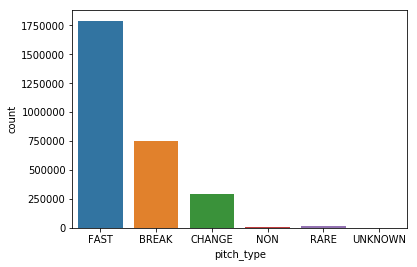

In [12]:
sns.countplot('pitch_type', data=df1)

Now look at this for right handers vs. lefties. The percentages are about the same. Lefties throw breaking balls about 3% more.

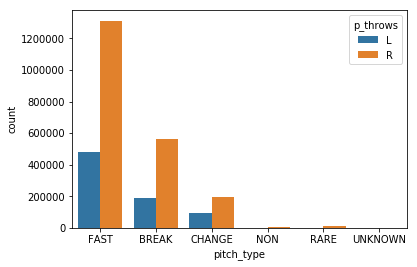

In [13]:
sns.countplot('pitch_type', hue='p_throws',data=df1)

In [14]:
df1.groupby('p_throws')['pitch_type'].value_counts(normalize=True)

p_throws  pitch_type
L         FAST          0.625200
          BREAK         0.245819
          CHANGE        0.126700
          NON           0.002204
          RARE          0.000050
          UNKNOWN       0.000027
R         FAST          0.627663
          BREAK         0.269897
          CHANGE        0.093808
          RARE          0.005760
          NON           0.002846
          UNKNOWN       0.000026
Name: pitch_type, dtype: float64

Now look at what left/right handed hitters typically see. Left handed hitters see more changeups proportionally and fewer curveballs.

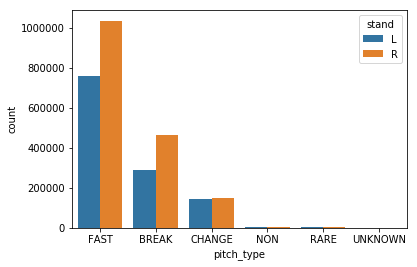

In [15]:
sns.countplot('pitch_type', hue='stand',data=df1)

In [16]:
df1.groupby('stand')['pitch_type'].value_counts(normalize=True)

stand  pitch_type
L      FAST          0.632488
       BREAK         0.240591
       CHANGE        0.119131
       RARE          0.004590
       NON           0.003169
       UNKNOWN       0.000032
R      FAST          0.623053
       BREAK         0.279902
       CHANGE        0.090736
       RARE          0.003969
       NON           0.002318
       UNKNOWN       0.000022
Name: pitch_type, dtype: float64

Now looking at pitch breakdown by starter and reliever. Relievers throw more fastballs and breaking balls but fewer changeup proportionally.

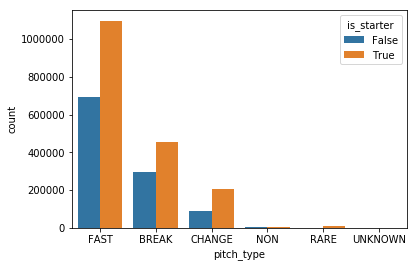

In [17]:
sns.countplot('pitch_type', hue='is_starter',data=df1)

In [18]:
df1.groupby('is_starter')['pitch_type'].value_counts(normalize=True)

is_starter  pitch_type
False       FAST          0.640734
            BREAK         0.273151
            CHANGE        0.080482
            NON           0.004739
            RARE          0.000869
            UNKNOWN       0.000024
True        FAST          0.618607
            BREAK         0.257505
            CHANGE        0.116166
            RARE          0.006284
            NON           0.001411
            UNKNOWN       0.000028
Name: pitch_type, dtype: float64

Checking for missing data or errors.

In [19]:
[max(df1['b_count']), max(df1['s_count']), max(df1['outs']), min(df1['b_count']), min(df1['s_count']), 
 min(df1['outs']), min(df1['b_score']), min(df1['p_score']), min(df1['pitch_num']), max(df1['pitch_num'])]

[4, 2, 2, 0, 0, 0, 0, 0, 1, 21]

There's an issue where there are 4 balls in an at bat. Shouldn't be occurring. Let's look at each at bat. The other numbers seem legitimate.

In [20]:
ab_errors = df1[df1['b_count']==4]['ab_id'].unique()
ab_errors

array([2.01501509e+09, 2.01504810e+09, 2.01514051e+09, 2.01712818e+09,
       2.01803481e+09, 2.01811906e+09, 2.01815500e+09])

There are only 7 messy atbats so we can look at them one at a time.

In [21]:
df1[df1['ab_id']==ab_errors[2]]

,ab_id,ax,ay,az,b_count,b_score,break_angle,break_length,break_y,code,end_speed,nasty,on_1b,on_2b,on_3b,outs,pfx_x,pfx_z,pitch_num,pitch_type,px,pz,s_count,spin_dir,spin_rate,start_speed,sz_bot,sz_top,type,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,zone,batter_id,event,g_id,inning,p_score,p_throws,pitcher_id,stand,top,is_starter
534597,2.015141e+09,-18.609,32.426,-19.632,0,0,39.3,5.7,23.8,C,86.2,46.0,False,False,False,0,-9.74,6.52,1,FAST,0.416,2.377,0,236.020,2362.332,94.1,1.72,3.44,S,0.913,6.999,-137.817,-4.975,101.14,-0.900,174.60,50.0,5.543,6.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True
534598,2.015141e+09,-8.063,27.760,-26.654,0,0,15.1,7.0,23.7,B,78.8,36.0,False,False,False,0,-5.03,3.40,2,CHANGE,-0.042,3.526,1,235.603,1122.451,86.2,1.53,3.42,B,0.898,4.111,-126.298,0.313,118.60,-1.043,143.58,50.0,5.559,11.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True
534599,2.015141e+09,-9.567,33.225,-15.293,1,0,26.3,3.8,23.7,F,86.9,60.0,False,False,False,0,-4.91,8.63,3,FAST,0.858,2.926,1,209.540,2023.189,95.0,1.53,3.28,S,0.914,6.322,-139.138,-4.486,84.30,-0.813,159.78,50.0,5.583,12.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True
534600,2.015141e+09,2.154,25.914,-27.811,1,0,-6.0,7.0,23.9,B,82.1,40.0,False,False,False,0,1.27,2.53,4,BREAK,1.217,0.598,2,153.726,546.809,88.2,1.58,3.38,B,0.925,5.225,-129.097,-6.927,70.61,-0.995,222.63,50.0,5.445,14.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True
534601,2.015141e+09,-10.043,34.042,-14.064,2,0,28.8,3.5,23.7,F,87.6,58.0,False,False,False,0,-5.07,9.11,5,FAST,1.169,3.084,2,209.010,2140.381,95.9,1.53,3.28,S,0.917,7.173,-140.364,-4.428,1.00,-0.769,1.00,50.0,5.608,12.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True
534602,2.015141e+09,-16.901,28.340,-26.520,2,0,30.1,7.9,23.8,B,80.5,52.0,False,False,False,0,-10.24,3.38,6,FAST,-0.782,1.078,2,251.503,2017.285,87.5,1.53,3.34,B,0.505,3.866,-128.169,-5.755,72.44,-0.986,155.51,50.0,5.444,13.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True
534603,2.015141e+09,-11.278,35.957,-15.516,3,0,30.3,3.9,23.7,B,86.9,68.0,False,False,False,0,-5.74,8.45,7,FAST,1.028,3.682,2,214.098,2080.880,95.8,1.53,3.28,B,0.890,7.152,-140.253,-2.593,146.81,-0.826,209.67,50.0,5.649,12.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True
534604,2.015141e+09,-9.342,32.922,-14.864,4,0,24.1,3.7,23.8,B,87.8,24.0,False,False,False,0,-4.73,8.72,8,FAST,1.861,2.146,2,208.354,2037.971,95.8,1.53,3.28,B,0.919,8.810,-140.026,-6.694,0.00,-0.718,0.00,50.0,5.548,14.0,514917,Walk,201501862.0,1,0,R,594798,L,False,True


From visual inspection, I can't make sense of why four balls were called. I'm guessing the umpire lost track of the number of balls. Since there are only 7 atbats with this type of occurance and 740820 total atbats, we will drop these observations because they are not good data. We will save this for the end, however, after we've done other things.

In [22]:
len(df1['ab_id'].unique())

740820

Now we can check pitch type, and batter/pitcher side just to make sure nothing was misentered.

In [23]:
Counter(df1['pitch_type'])

Counter({'FAST': 1790241,
         'BREAK': 752190,
         'CHANGE': 293019,
         'NON': 7635,
         nan: 14198,
         'RARE': 12075,
         'UNKNOWN': 75})

We will put the NA pitches into the unknown category. I am assuming that the NA pitches were left blank because the type was not determined.

In [24]:
df1['pitch_type'].replace(np.nan, 'UNKNOWN', inplace=True)

Checking out pitch side and batting side.

In [25]:
Counter(df1['p_throws'])

Counter({'L': 769283, 'R': 2100150})

In [26]:
Counter(df1['stand'])

Counter({'L': 1202367, 'R': 1667066})

It all checks out. The data look clean to go on ahead.

We're going to drop some variables that we don't initially need. For now, we are just focusing on situation, and ignoring the outcome of previous atbats. We are, however, including batter_id and pitcher_id because this might tell us what pitches pitchers prefer and what pitches are usually thrown at certain hitters.

We don't want to keep the type for the current at bat but we want to look at the type of the previous atbat so we will keep it for now. Same note for the code. Code appears to be the same thing as type but more descriptive so we might just drop type all together later. I might also want to look at how previous pitches are breaking, spinning, etc. to see if a pitcher is struggling with a certain type of pitch. This might not be that important, though

In [27]:
df1.drop(['ax', 'ay', 'az', 'break_angle', 'break_length', 'break_y', 'end_speed', 'nasty', 'pfx_x', 'pfx_z',
        'px', 'pz', 'spin_dir', 'spin_rate', 'start_speed', 'sz_bot', 'sz_top', 'type_confidence', 'vx0',
        'vy0', 'vz0', 'x', 'x0', 'y', 'y0', 'z0', 'zone', 'event'], axis=1, inplace=True)

In [28]:
df1.head()

,ab_id,b_count,b_score,code,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,type,batter_id,g_id,inning,p_score,p_throws,pitcher_id,stand,top,is_starter
0,2.015000e+09,0,0,C,False,False,False,0,1,FAST,0,S,572761,201500001.0,1,0,L,452657,L,True,True
1,2.015000e+09,0,0,S,False,False,False,0,2,FAST,1,S,572761,201500001.0,1,0,L,452657,L,True,True
2,2.015000e+09,0,0,F,False,False,False,0,3,FAST,2,S,572761,201500001.0,1,0,L,452657,L,True,True
3,2.015000e+09,0,0,B,False,False,False,0,4,FAST,2,B,572761,201500001.0,1,0,L,452657,L,True,True
4,2.015000e+09,1,0,B,False,False,False,0,5,BREAK,2,B,572761,201500001.0,1,0,L,452657,L,True,True


Now that I've dropped the variables I don't need, I want to look at missing data.

In [29]:
missing = pd.DataFrame(df1.isnull().sum()).rename(columns={0: 'total'})
missing['percent'] = missing['total'] / len(df1)
missing.sort_values('percent', ascending=False).head()

,total,percent
code,13510,0.004708
ab_id,0,0.000000
type,0,0.000000
top,0,0.000000
stand,0,0.000000


The only one is code. I want to take a look at it.

In [30]:
Counter(df1['code'])

Counter({'C': 481119,
         'S': 271511,
         'F': 496767,
         'B': 957122,
         'X': 331029,
         'D': 117181,
         'E': 64198,
         '*B': 65697,
         'L': 8472,
         'W': 23150,
         'T': 23964,
         'I': 6588,
         'M': 1845,
         nan: 13510,
         'P': 619,
         'V': 6652,
         'Q': 6,
         'R': 2,
         'Z': 1})

I'm going to check the mean of the game id to see if earlier games had more missing values.

In [31]:
print(np.mean(df1['g_id']), np.mean(df1[df1['code'].isnull()]['g_id']))

201652514.85480687 201584360.14492968


That looks like it's the case, so I can't drop the bad observations because it's not completely random. Instead I will fill it in with the most common value ('B'). Also, changing intentional ball to 'starB' to make dummy variables easier later.

In [32]:
df1['code'].replace(np.nan, 'B', inplace=True)
df1['code'].replace('*B', 'starB', inplace=True)

# Feature Engineering

Convert boolean variables to 1/0

In [33]:
tf_vars = ['on_1b', 'on_2b', 'on_3b', 'top', 'is_starter']

for var in tf_vars:
    df1[var] = df1[var] * 1

df1['p_throws'].replace('R', 1, inplace=True)
df1['p_throws'].replace('L', 0, inplace=True)
df1['stand'].replace('R', 1, inplace=True)
df1['stand'].replace('L', 0, inplace=True)

In [34]:
df1.head()

,ab_id,b_count,b_score,code,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,type,batter_id,g_id,inning,p_score,p_throws,pitcher_id,stand,top,is_starter
0,2.015000e+09,0,0,C,0,0,0,0,1,FAST,0,S,572761,201500001.0,1,0,0,452657,0,1,1
1,2.015000e+09,0,0,S,0,0,0,0,2,FAST,1,S,572761,201500001.0,1,0,0,452657,0,1,1
2,2.015000e+09,0,0,F,0,0,0,0,3,FAST,2,S,572761,201500001.0,1,0,0,452657,0,1,1
3,2.015000e+09,0,0,B,0,0,0,0,4,FAST,2,B,572761,201500001.0,1,0,0,452657,0,1,1
4,2.015000e+09,1,0,B,0,0,0,0,5,BREAK,2,B,572761,201500001.0,1,0,0,452657,0,1,1


We're left with 4 id variables.

We have several quantitative variables.

And 3 remaining categorical variables (including the target variable). We will leave the 2 categorical features this way until the end and we can do one-hot encoding.

Create variable that shows the previous pitch type in the at bat and one that shows the previous outcome (swinging strike, flyout, etc.). If it's the first pitch of the atbat, we will put 'first' for each variable.

First I will copy make a copy of the data and stagger the pitch number by 1 (keeping the at bat consistent)

In [35]:
df1['prev_pitch'] = df1['pitch_num'] - 1
df2 = df1

df3 = df1.merge(df2, left_on=['ab_id', 'prev_pitch'], right_on=['ab_id', 'pitch_num'], how='left', 
                suffixes=('_1', '_2'))

df3 = df3[['ab_id', 'pitch_num_1', 'pitch_num_2', 'pitch_type_1', 'pitch_type_2', 'code_1', 'code_2']]
df3['prev_type'] = df3['pitch_type_2']
df3['prev_outcome'] = df3['code_2']
df3.rename(columns={'pitch_num_1':'pitch_num'}, inplace=True)
df3 = df3[['ab_id', 'pitch_num', 'prev_type', 'prev_outcome']]
df3.head(10)

,ab_id,pitch_num,prev_type,prev_outcome
0,2.015000e+09,1,NaN,NaN
1,2.015000e+09,2,FAST,C
2,2.015000e+09,3,FAST,S
3,2.015000e+09,4,FAST,F
4,2.015000e+09,5,FAST,B
5,2.015000e+09,6,BREAK,B
6,2.015000e+09,1,NaN,NaN
7,2.015000e+09,2,FAST,B
8,2.015000e+09,1,NaN,NaN
9,2.015000e+09,2,FAST,B


Now I can add the previous pitch typpe and outcome back into the original data, using the at bat id and pitch number. (I am also dropping the prev_pitch variable because that was just helping me track the number of pitches)

In [36]:
df1 = df1.merge(df3, on=['ab_id', 'pitch_num'])
df1.drop('prev_pitch', axis=1, inplace=True)
df1.head(10)

,ab_id,b_count,b_score,code,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,type,batter_id,g_id,inning,p_score,p_throws,pitcher_id,stand,top,is_starter,prev_type,prev_outcome
0,2.015000e+09,0,0,C,0,0,0,0,1,FAST,0,S,572761,201500001.0,1,0,0,452657,0,1,1,NaN,NaN
1,2.015000e+09,0,0,S,0,0,0,0,2,FAST,1,S,572761,201500001.0,1,0,0,452657,0,1,1,FAST,C
2,2.015000e+09,0,0,F,0,0,0,0,3,FAST,2,S,572761,201500001.0,1,0,0,452657,0,1,1,FAST,S
3,2.015000e+09,0,0,B,0,0,0,0,4,FAST,2,B,572761,201500001.0,1,0,0,452657,0,1,1,FAST,F
4,2.015000e+09,1,0,B,0,0,0,0,5,BREAK,2,B,572761,201500001.0,1,0,0,452657,0,1,1,FAST,B
5,2.015000e+09,2,0,X,0,0,0,0,6,FAST,2,X,572761,201500001.0,1,0,0,452657,0,1,1,BREAK,B
6,2.015000e+09,0,0,B,0,0,0,1,1,FAST,0,B,518792,201500001.0,1,0,0,452657,0,1,1,NaN,NaN
7,2.015000e+09,1,0,D,0,0,0,1,2,FAST,0,X,518792,201500001.0,1,0,0,452657,0,1,1,FAST,B
8,2.015000e+09,0,0,B,0,1,0,1,1,FAST,0,B,407812,201500001.0,1,0,0,452657,1,1,1,NaN,NaN
9,2.015000e+09,1,0,B,0,1,0,1,2,FAST,0,B,407812,201500001.0,1,0,0,452657,1,1,1,FAST,B


The NaN pitch previous types and previous codes are for the first pitch of the atbat. So I will rename them '1ST'

In [37]:
df1['prev_type'].replace(np.nan, '1ST', inplace=True)
df1['prev_outcome'].replace(np.nan, '1ST', inplace=True)

Drop the code and type variables (Decide later if we want to replace the pre_outcome variable with previouse type info instead of previous code info)

In [38]:
df1.drop(['code', 'type'], axis=1, inplace=True)

Turn the score variables into a score differential

In [39]:
df1['score_diff'] = df1['p_score'] - df1['b_score']

df1.drop(['p_score', 'b_score'], axis=1, inplace=True)

In [40]:
df1.head()

,ab_id,b_count,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,batter_id,g_id,inning,p_throws,pitcher_id,stand,top,is_starter,prev_type,prev_outcome,score_diff
0,2.015000e+09,0,0,0,0,0,1,FAST,0,572761,201500001.0,1,0,452657,0,1,1,1ST,1ST,0
1,2.015000e+09,0,0,0,0,0,2,FAST,1,572761,201500001.0,1,0,452657,0,1,1,FAST,C,0
2,2.015000e+09,0,0,0,0,0,3,FAST,2,572761,201500001.0,1,0,452657,0,1,1,FAST,S,0
3,2.015000e+09,0,0,0,0,0,4,FAST,2,572761,201500001.0,1,0,452657,0,1,1,FAST,F,0
4,2.015000e+09,1,0,0,0,0,5,BREAK,2,572761,201500001.0,1,0,452657,0,1,1,FAST,B,0


Create a feature that counts how many pitches a pitcher has thrown so far in a game.

In [41]:
df1['pitch_count'] = df1.groupby(['g_id', 'pitcher_id']).cumcount()

Check to see if I did it right by looking at the max pitch count.

In [42]:
max(df1['pitch_count'])

133

Seems reasonable

Now I want to see how many pitches a pitcher has thrown of each pitch type. I want to use cumcount again but I need 6 different variables so I will make dummy variables for pitch type and then delete them again. 

In [43]:
df1['type_fast'] = (df1['pitch_type'] == 'FAST') * 1
df1['type_break'] = (df1['pitch_type'] == 'BREAK') * 1
df1['type_change'] = (df1['pitch_type'] == 'CHANGE') * 1
df1['type_non'] = (df1['pitch_type'] == 'NON') * 1
df1['type_rare'] = (df1['pitch_type'] == 'RARE') * 1
df1['type_unknown'] = (df1['pitch_type'] == 'UNKNOWN') * 1

Now I can make 6 variables for the cumulative count for each pitch type. And I will also create a total number of pitches thrown so I can find proportions of each pitch thrown.

In [44]:
df1['pitches_fast'] = df1.groupby('pitcher_id')['type_fast'].cumsum()
df1['pitches_break'] = df1.groupby('pitcher_id')['type_break'].cumsum()
df1['pitches_change'] = df1.groupby('pitcher_id')['type_change'].cumsum()
df1['pitches_non'] = df1.groupby('pitcher_id')['type_non'].cumsum()
df1['pitches_rare'] = df1.groupby('pitcher_id')['type_rare'].cumsum()
df1['pitches_unknown'] = df1.groupby('pitcher_id')['type_unknown'].cumsum()
df1['pitches_total'] = df1['pitches_fast'] + df1['pitches_break'] + df1['pitches_change'] + df1['pitches_non']
df1['pitches_total'] = df1['pitches_total'] + df1['pitches_rare'] + df1['pitches_unknown']

df1.drop(['type_fast', 'type_break', 'type_change', 'type_non', 'type_rare', 'type_unknown'], axis=1, inplace=True)
df1.tail(30)

,ab_id,b_count,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,batter_id,g_id,inning,p_throws,pitcher_id,stand,top,is_starter,prev_type,prev_outcome,score_diff,pitch_count,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total
2869403,2.018186e+09,1,1,0,0,1,2,FAST,0,456124,201802434.0,9,0,448802,1,1,0,FAST,B,-2,6,5156,1724,1380,13,0,47,8320
2869404,2.018186e+09,2,1,0,0,1,3,FAST,0,456124,201802434.0,9,0,448802,1,1,0,FAST,B,-2,7,5157,1724,1380,13,0,47,8321
2869405,2.018186e+09,2,1,0,0,1,4,FAST,1,456124,201802434.0,9,0,448802,1,1,0,FAST,C,-2,8,5158,1724,1380,13,0,47,8322
2869406,2.018186e+09,0,1,0,0,2,1,FAST,0,606115,201802434.0,9,0,448802,1,1,0,1ST,1ST,-2,9,5159,1724,1380,13,0,47,8323
2869407,2.018186e+09,1,1,0,0,2,2,FAST,0,606115,201802434.0,9,0,448802,1,1,0,FAST,B,-2,10,5160,1724,1380,13,0,47,8324
2869408,2.018186e+09,1,1,0,0,2,3,FAST,1,606115,201802434.0,9,0,448802,1,1,0,FAST,F,-2,11,5161,1724,1380,13,0,47,8325
2869409,2.018186e+09,0,1,1,0,2,1,FAST,0,543768,201802434.0,9,0,448802,0,1,0,1ST,1ST,-2,12,5162,1724,1380,13,0,47,8326
2869410,2.018186e+09,1,1,1,0,2,2,FAST,0,543768,201802434.0,9,0,448802,0,1,0,FAST,B,-2,13,5163,1724,1380,13,0,47,8327
2869411,2.018186e+09,1,1,1,0,2,3,BREAK,1,543768,201802434.0,9,0,448802,0,1,0,FAST,S,-2,14,5163,1725,1380,13,0,47,8328
2869412,2.018186e+09,0,0,0,0,0,1,FAST,0,502517,201802434.0,9,0,623352,0,0,0,1ST,1ST,2,14,1673,360,64,0,0,7,2104


The cumulative pitch type sum variables are looking good.

Now I want to get the proportion of each pitch type thrown and throw out the total pitches

In [45]:
pitch_vars = ['pitches_fast', 'pitches_break', 'pitches_change', 'pitches_non', 'pitches_rare', 'pitches_unknown']
for var in pitch_vars:
    df1[var] = df1[var].astype(float) / df1['pitches_total']

Check the head and tail to make sure it looks right

In [46]:
df1.head(10)

,ab_id,b_count,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,batter_id,g_id,inning,p_throws,pitcher_id,stand,top,is_starter,prev_type,prev_outcome,score_diff,pitch_count,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total
0,2.015000e+09,0,0,0,0,0,1,FAST,0,572761,201500001.0,1,0,452657,0,1,1,1ST,1ST,0,0,1.000000,0.000000,0.0,0.0,0.0,0.0,1
1,2.015000e+09,0,0,0,0,0,2,FAST,1,572761,201500001.0,1,0,452657,0,1,1,FAST,C,0,1,1.000000,0.000000,0.0,0.0,0.0,0.0,2
2,2.015000e+09,0,0,0,0,0,3,FAST,2,572761,201500001.0,1,0,452657,0,1,1,FAST,S,0,2,1.000000,0.000000,0.0,0.0,0.0,0.0,3
3,2.015000e+09,0,0,0,0,0,4,FAST,2,572761,201500001.0,1,0,452657,0,1,1,FAST,F,0,3,1.000000,0.000000,0.0,0.0,0.0,0.0,4
4,2.015000e+09,1,0,0,0,0,5,BREAK,2,572761,201500001.0,1,0,452657,0,1,1,FAST,B,0,4,0.800000,0.200000,0.0,0.0,0.0,0.0,5
5,2.015000e+09,2,0,0,0,0,6,FAST,2,572761,201500001.0,1,0,452657,0,1,1,BREAK,B,0,5,0.833333,0.166667,0.0,0.0,0.0,0.0,6
6,2.015000e+09,0,0,0,0,1,1,FAST,0,518792,201500001.0,1,0,452657,0,1,1,1ST,1ST,0,6,0.857143,0.142857,0.0,0.0,0.0,0.0,7
7,2.015000e+09,1,0,0,0,1,2,FAST,0,518792,201500001.0,1,0,452657,0,1,1,FAST,B,0,7,0.875000,0.125000,0.0,0.0,0.0,0.0,8
8,2.015000e+09,0,0,1,0,1,1,FAST,0,407812,201500001.0,1,0,452657,1,1,1,1ST,1ST,0,8,0.888889,0.111111,0.0,0.0,0.0,0.0,9
9,2.015000e+09,1,0,1,0,1,2,FAST,0,407812,201500001.0,1,0,452657,1,1,1,FAST,B,0,9,0.900000,0.100000,0.0,0.0,0.0,0.0,10


In [47]:
df1.tail(10)

,ab_id,b_count,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,batter_id,g_id,inning,p_throws,pitcher_id,stand,top,is_starter,prev_type,prev_outcome,score_diff,pitch_count,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total
2869423,2.018186e+09,3,0,0,0,2,4,FAST,0,595879,201802434.0,9,0,623352,1,0,0,FAST,B,2,25,0.794799,0.171631,0.030260,0.0,0.0,0.003310,2115
2869424,2.018186e+09,3,0,0,0,2,5,FAST,1,595879,201802434.0,9,0,623352,1,0,0,FAST,C,2,26,0.794896,0.171550,0.030246,0.0,0.0,0.003308,2116
2869425,2.018186e+09,3,0,0,0,2,6,FAST,2,595879,201802434.0,9,0,623352,1,0,0,FAST,C,2,27,0.794993,0.171469,0.030231,0.0,0.0,0.003307,2117
2869426,2.018186e+09,3,0,0,0,2,7,FAST,2,595879,201802434.0,9,0,623352,1,0,0,FAST,F,2,28,0.795090,0.171388,0.030217,0.0,0.0,0.003305,2118
2869427,2.018186e+09,3,0,0,0,2,8,FAST,2,595879,201802434.0,9,0,623352,1,0,0,FAST,F,2,29,0.795186,0.171307,0.030203,0.0,0.0,0.003303,2119
2869428,2.018186e+09,3,0,0,0,2,9,BREAK,2,595879,201802434.0,9,0,623352,1,0,0,FAST,F,2,30,0.794811,0.171698,0.030189,0.0,0.0,0.003302,2120
2869429,2.018186e+09,0,1,0,0,2,1,FAST,0,519203,201802434.0,9,0,623352,0,0,0,1ST,1ST,2,31,0.794908,0.171617,0.030174,0.0,0.0,0.003300,2121
2869430,2.018186e+09,1,0,1,0,2,2,FAST,0,519203,201802434.0,9,0,623352,0,0,0,FAST,B,2,32,0.795005,0.171536,0.030160,0.0,0.0,0.003299,2122
2869431,2.018186e+09,1,0,1,0,2,3,FAST,1,519203,201802434.0,9,0,623352,0,0,0,FAST,F,2,33,0.795101,0.171455,0.030146,0.0,0.0,0.003297,2123
2869432,2.018186e+09,1,0,1,0,2,4,FAST,2,519203,201802434.0,9,0,623352,0,0,0,FAST,S,2,34,0.795198,0.171375,0.030132,0.0,0.0,0.003296,2124


I want to merge these variables with the pitcher data. This step is intended for when I do prediction later, and won't be included for modelling. I only need to do this once and then I can save it as a new file, rewriting over player_names.csv.

I will use the last row for each pitcher and merge that with player_names.

In [48]:
# pitches_to_date = df1.drop_duplicates(subset='pitcher_id', keep='last')
# pitches_to_date[(pitches_to_date['pitcher_id'] == 452657) | (pitches_to_date['pitcher_id'] == 425794)]

Checking the output for Jon Lester and Adam Wainwright, it looks good.

Now I want to merge these variables into the player names dataset as a place to store for predictions later.

In [49]:
# #Keeping only pitcher id and the variables I want to merge from pitches_to_date
# pitches_to_date = pitches_to_date[['pitcher_id', 'pitches_fast', 'pitches_break', 'pitches_change', 'pitches_non', 
#                                   'pitches_rare', 'pitches_unknown', 'pitches_total']]

# #Merging
# player_names = player_names.merge(pitches_to_date, how='left', left_on='id', right_on='pitcher_id')
# player_names.drop('pitcher_id', axis=1, inplace=True)
# player_names.head()

That looks good. Now I want to output this to player_names.csv.

In [50]:
# player_names.to_csv('player_names.csv')

I've done all the feature engineering I want to do. Now I will drop those problem observations.

In [51]:
df1 = df1[~df1.ab_id.isin(ab_errors)]

Look at our data one last time before I start modelling

In [52]:
df1.head()

,ab_id,b_count,on_1b,on_2b,on_3b,outs,pitch_num,pitch_type,s_count,batter_id,g_id,inning,p_throws,pitcher_id,stand,top,is_starter,prev_type,prev_outcome,score_diff,pitch_count,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total
0,2.015000e+09,0,0,0,0,0,1,FAST,0,572761,201500001.0,1,0,452657,0,1,1,1ST,1ST,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,2.015000e+09,0,0,0,0,0,2,FAST,1,572761,201500001.0,1,0,452657,0,1,1,FAST,C,0,1,1.0,0.0,0.0,0.0,0.0,0.0,2
2,2.015000e+09,0,0,0,0,0,3,FAST,2,572761,201500001.0,1,0,452657,0,1,1,FAST,S,0,2,1.0,0.0,0.0,0.0,0.0,0.0,3
3,2.015000e+09,0,0,0,0,0,4,FAST,2,572761,201500001.0,1,0,452657,0,1,1,FAST,F,0,3,1.0,0.0,0.0,0.0,0.0,0.0,4
4,2.015000e+09,1,0,0,0,0,5,BREAK,2,572761,201500001.0,1,0,452657,0,1,1,FAST,B,0,4,0.8,0.2,0.0,0.0,0.0,0.0,5


In [53]:
len(df1) / float(len(pitches))

0.9999790899456443

We still have 99.998% of our original data. Pretty good

# Modelling

In [54]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.externals import joblib 
import pickle
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

Get the target, and the features. I can't use the ids (including batter/pitcher) because that would be too many indicator variables and would make the model too complex.

I'm going to try taking a random sample of the data because the model takes too long to run for 3 million observations.

In [55]:
data = df1.sample(n=250000, random_state=42)

In [56]:
labels = np.array(data['pitch_type'])
data = data.drop(columns = ['ab_id', 'g_id', 'pitch_type', 'batter_id', 'pitcher_id'])
train_data = data

Check if I missed columns with missing data. 

In [57]:
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0: 'total'})
missing['percent'] = missing['total'] / len(data)
missing.sort_values('percent', ascending=False).head()

,total,percent
b_count,0,0.0
prev_type,0,0.0
pitches_unknown,0,0.0
pitches_rare,0,0.0
pitches_non,0,0.0


Nope, all good.

I need to get dummy variables for my categorical variables.

In [58]:
data.dtypes

b_count              int64
on_1b                int64
on_2b                int64
on_3b                int64
outs                 int64
pitch_num            int64
s_count              int64
inning               int64
p_throws             int64
stand                int64
top                  int64
is_starter           int64
prev_type           object
prev_outcome        object
score_diff           int64
pitch_count          int64
pitches_fast       float64
pitches_break      float64
pitches_change     float64
pitches_non        float64
pitches_rare       float64
pitches_unknown    float64
pitches_total        int64
dtype: object

I can do one-hot encoding to get indicator variables for prev_type and prev_outcome.

In [59]:
data = pd.get_dummies(data, drop_first=True)

In [60]:
data.head()

,b_count,on_1b,on_2b,on_3b,outs,pitch_num,s_count,inning,p_throws,stand,top,is_starter,score_diff,pitch_count,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total,prev_type_BREAK,prev_type_CHANGE,prev_type_FAST,prev_type_NON,prev_type_RARE,prev_type_UNKNOWN,prev_outcome_B,prev_outcome_C,prev_outcome_F,prev_outcome_I,prev_outcome_L,prev_outcome_M,prev_outcome_P,prev_outcome_Q,prev_outcome_S,prev_outcome_T,prev_outcome_V,prev_outcome_W,prev_outcome_starB
2636979,0,0,0,0,0,1,0,4,1,1,1,1,4,66,0.492970,0.417225,0.088216,0.000084,0.0,0.001507,11948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2001704,0,0,0,0,1,1,0,2,1,0,1,1,0,16,0.576061,0.299239,0.120697,0.002602,0.0,0.001401,4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
327847,2,1,0,0,1,3,0,1,1,1,1,1,0,6,0.552588,0.133556,0.313856,0.000000,0.0,0.000000,1198,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
601552,3,1,0,0,2,5,1,5,1,1,1,1,5,92,0.655113,0.230936,0.113951,0.000000,0.0,0.000000,2308,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1686988,1,0,0,0,0,4,2,8,1,0,0,0,2,3,0.541833,0.449203,0.002988,0.000000,0.0,0.005976,1004,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Ran a model and I have high variance so I want to use a smaller set of features.

Dropping all the previous outcome dummy variables that occur less than 1% of the time.

In [61]:
prev_outcome = [col for col in data if col.startswith('prev_outcome')]
(np.mean(data[prev_outcome]) > .01)

prev_outcome_B         True
prev_outcome_C         True
prev_outcome_F         True
prev_outcome_I        False
prev_outcome_L        False
prev_outcome_M        False
prev_outcome_P        False
prev_outcome_Q        False
prev_outcome_S         True
prev_outcome_T        False
prev_outcome_V        False
prev_outcome_W        False
prev_outcome_starB     True
dtype: bool

In [62]:
# data.drop(['prev_outcome_I', 'prev_outcome_L', 'prev_outcome_M', 'prev_outcome_P', 'prev_outcome_Q', 'prev_outcome_R',
#            'prev_outcome_T', 'prev_outcome_V', 'prev_outcome_W'], axis=1, inplace=True)

data.drop(['prev_outcome_I', 'prev_outcome_L', 'prev_outcome_M', 'prev_outcome_P', 'prev_outcome_Q',
           'prev_outcome_T', 'prev_outcome_V', 'prev_outcome_W'], axis=1, inplace=True)

In [63]:
data.head()

,b_count,on_1b,on_2b,on_3b,outs,pitch_num,s_count,inning,p_throws,stand,top,is_starter,score_diff,pitch_count,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total,prev_type_BREAK,prev_type_CHANGE,prev_type_FAST,prev_type_NON,prev_type_RARE,prev_type_UNKNOWN,prev_outcome_B,prev_outcome_C,prev_outcome_F,prev_outcome_S,prev_outcome_starB
2636979,0,0,0,0,0,1,0,4,1,1,1,1,4,66,0.492970,0.417225,0.088216,0.000084,0.0,0.001507,11948,0,0,0,0,0,0,0,0,0,0,0
2001704,0,0,0,0,1,1,0,2,1,0,1,1,0,16,0.576061,0.299239,0.120697,0.002602,0.0,0.001401,4996,0,0,0,0,0,0,0,0,0,0,0
327847,2,1,0,0,1,3,0,1,1,1,1,1,0,6,0.552588,0.133556,0.313856,0.000000,0.0,0.000000,1198,0,1,0,0,0,0,1,0,0,0,0
601552,3,1,0,0,2,5,1,5,1,1,1,1,5,92,0.655113,0.230936,0.113951,0.000000,0.0,0.000000,2308,0,0,1,0,0,0,1,0,0,0,0
1686988,1,0,0,0,0,4,2,8,1,0,0,0,2,3,0.541833,0.449203,0.002988,0.000000,0.0,0.005976,1004,0,0,1,0,0,0,1,0,0,0,0


In [65]:
train_data = data
data.shape

(250000, 32)

Scale the data

In [66]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

Get the train/test split to use in the models

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data, labels)

Do some preliminary checks on different models to see which are the best

In [68]:
def test_clf(clf):
#     clf.fit(X_train, y_train)
#     y_pred_test = clf.predict(X_test)
#     print(clf.__class__.__name__)
#     print(classification_report(y_test, y_pred_test))
    score = cross_val_score(clf, X_train, y_train, scoring = 'f1_macro', cv = 3)
    print(clf.__class__.__name__,"Score =", score.mean())

The 5 classification models I want to try are KNN, Naive Bayes, SVM, Random Forest, and Gradient Boost.

Trying it incrementally with different amounts of data. Super slow with all the data. For 10000 random rows, they all run under 12 seconds. Note that Naive Bayes is pretty awful so I'll throw it out.

For 50000 observations, the 4 remaininng models perform similarly. But Support Vector takes about 4 minutes which is too long for only 50000 so I'll drop that one.

In [179]:
knn = KNeighborsClassifier()
nb = GaussianNB()
svc = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

models = [knn, rf, gb]

for clf in models:
    start = time()
    
    test_clf(clf)
    
    end = time()
    print('Time Elapsed:', end - start)

KNeighborsClassifier Score = 0.5926399116345563
Time Elapsed: 517.8313148021698
RandomForestClassifier Score = 0.578500099596244
Time Elapsed: 5.1685850620269775
GradientBoostingClassifier Score = 0.5641764321480784
Time Elapsed: 264.74239706993103


Random Forest is a lot faster than K Nearest Neighbors and Gradient Boosting so I'll start with that one.

# Random Forest

Hyperparameter Grid

In [68]:
# Number of trees in random forest
#n_estimators = [10, 50, 100]
n_estimators = [50, 100, 200]
# Number of features to consider at every split
#max_features = [5, 10, 15]
#max_features = [3, 5, 8]
max_features = [4,5,6]
# Maximum number of levels in tree
#max_depth = [1, 8, 15]
max_depth = [12,15,18]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
#min_samples_split = [7, 10, 13]
min_samples_split = [7,8,10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
#min_samples_leaf = [2, 4, 6]
min_samples_leaf = [2,3,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Class weights since we have imbalanced classes
class_weights = ['balanced', 'balanced_subsample']
class_weights.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weights}

Tune hyperparameters, using 3-fold cross validation

In [69]:
start=time()
rf = RandomForestClassifier(n_jobs=-1) ###The -1 here is more important because trees can be run together

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, 
                               random_state=42, n_jobs = 1, scoring='f1_macro')

rf_random.fit(X_train, y_train)
end=time()
print('Time Elapsed:', (end - start) / 60)

best_random = rf_random.best_estimator_
print(best_random)

y_pred_test = best_random.predict(X_test)
y_pred_train = best_random.predict(X_train)
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Time Elapsed: 41.65376135110855
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Test Classification Report:
              precision    recall  f1-score   support

       BREAK       0.47      0.43      0.45     16570
      CHANGE       0.34      0.29      0.31      6319
        FAST       0.71      0.75      0.73     38880
         NON       0.74      0.65      0.69       167
        RARE       0.81      0.96      0.88       249
     UNKNOWN       0.73      0.54      0.62       315

   micro avg       0.62      0.62      0.62     62500
   macro avg       0.63      0.60      0.61     62500
weighted avg       0.61    

I tried to account for the overfitting by using fewer features, increasing the amount of data used to train the model, and increasing the number of cross validations, but the model was still severly overfit.

Save the model

In [70]:
joblib.dump(best_random, 'rf_mod.pkl')

['rf_mod.pkl']

Feature Importances

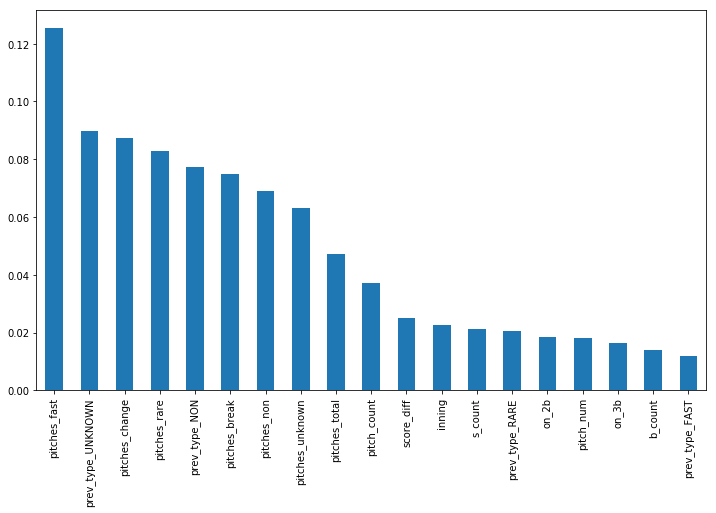

In [102]:
feature_imp = sorted(list(zip(train_data.columns, best_random.feature_importances_)), 
                     key=lambda x: x[1], reverse=True)[0:19]
plt.figure(figsize = (12,7))
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

It looks like the most important features have to do with what types of pitches a pitcher has thrown in the past. Also, pitch count and score differential are important.

### Now looking to K-Nearest Neighbors and Gradient Boosting

Tried downsampling fastballs and breaking balls to account for uneven class sizes. Made the KNN and GB models much worse so I'll just use my imbalanced classes

Downsample fastball and breaking ball to be as heavy as changeups. This is for the GB and KNN models which don't do it for me like RF.

In [76]:
# resampled = df1.sample(n=500000, random_state=42)
# num_change = len(resampled[resampled['pitch_type']=='CHANGE'])
# data_fast = resampled[resampled.pitch_type=='FAST']
# data_break = resampled[resampled.pitch_type=='BREAK']
# data_rest = resampled[(resampled.pitch_type!='FAST') & (resampled.pitch_type!='BREAK')]

# fast_down = resample(data_fast, replace=False, n_samples=num_change, random_state=123)
# break_down = resample(data_break, replace=False, n_samples=num_change, random_state=123)

# resampled = pd.concat([fast_down, break_down])
# resampled = pd.concat([resampled, data_rest])
 
# # Display new class counts
# resampled.pitch_type.value_counts()

CHANGE     51150
BREAK      51150
FAST       51150
UNKNOWN     2379
RARE        2150
NON         1376
Name: pitch_type, dtype: int64

Looks good to use (we don't care too much about the unknown, rare, and non classes since those will occur very infrequently). But we want to make sure we predict changeups and breaking balls every once in a while instead of just fastballs.

One hot encoding, scale the data, train/test split

In [77]:
# re_labels = np.array(resampled['pitch_type'])
# re_data = resampled.drop(columns = ['ab_id', 'g_id', 'pitch_type', 'batter_id', 'pitcher_id'])
# re_train_data = re_data

# re_data = pd.get_dummies(re_data, drop_first=True)

In [78]:
# re_data.head()

,b_count,on_1b,on_2b,on_3b,outs,pitch_num,s_count,inning,p_throws,stand,top,is_starter,score_diff,pitch_count,pitches_fast,pitches_break,pitches_change,pitches_non,pitches_rare,pitches_unknown,pitches_total,prev_type_BREAK,prev_type_CHANGE,prev_type_FAST,prev_type_NON,prev_type_RARE,prev_type_UNKNOWN,prev_outcome_B,prev_outcome_C,prev_outcome_F,prev_outcome_I,prev_outcome_L,prev_outcome_M,prev_outcome_P,prev_outcome_S,prev_outcome_T,prev_outcome_V,prev_outcome_W,prev_outcome_starB
1816094,1,0,0,0,2,3,1,2,1,0,0,1,-1,32,0.900393,0.095043,0.000000,0.001888,0.0,0.002675,6355,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2809023,1,0,0,0,2,3,1,3,1,0,1,1,-3,51,0.649018,0.186794,0.161214,0.000000,0.0,0.002974,1681,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2379331,1,0,0,0,0,3,1,7,0,0,0,0,3,2,0.927953,0.067300,0.000559,0.001955,0.0,0.002234,3581,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
573129,1,0,0,0,0,2,0,10,1,1,1,0,0,1,0.872970,0.122254,0.000000,0.004776,0.0,0.000000,1047,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
154664,2,0,0,0,0,4,1,4,1,0,1,1,-1,60,0.617166,0.339237,0.040872,0.000000,0.0,0.002725,734,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Dropping the prev outcome variables to match the original models

In [80]:
# re_data.drop(['prev_outcome_I', 'prev_outcome_L', 'prev_outcome_M', 'prev_outcome_P',
#            'prev_outcome_T', 'prev_outcome_V', 'prev_outcome_W'], axis=1, inplace=True)

In [81]:
# re_data.shape

(159355, 32)

In [82]:
# scaler = StandardScaler()
# scaler.fit(re_data)
# re_data = scaler.transform(re_data)
# X_re_train, X_re_test, y_re_train, y_re_test = train_test_split(re_data, re_labels)

# K Nearest Neighbors

Not too many hyperparameters to tune so I'll use gridsearch

In [74]:
n_neighbors = [3,5,7]
weights = ['uniform', 'distance']
p = [1,2]

# Create the random grid
grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'p': p}

In [76]:
start=time()
knn = KNeighborsClassifier(n_jobs=-1)

knn_grid = GridSearchCV(estimator = knn, param_grid = grid, cv = 3, n_jobs = 1, scoring='f1_macro')

knn_grid.fit(X_train, y_train)

end=time()
print('Time Elapsed:', (end - start) / 60)

best_knn = knn_grid.best_estimator_
print(best_knn)

y_pred_test = best_knn.predict(X_test)
y_pred_train = best_knn.predict(X_train)
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

The K-Nearest Neighbors model did not perform as well as the Random Forest or Gradient Boosting models so I will not use it for prediction. Note that it could only be run on very small sample sizes (~50000) so its output for the 250000 sample is not displayed.

# Gradient Boosting Classifier

In [70]:
learning_rate = [.1, .01, .001]
n_estimators = [50, 100, 200]
max_depth = [1, 3]

# Create the random grid
grid = {'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'max_depth': max_depth}

In [72]:
start=time()
gb = GradientBoostingClassifier()

gb_grid = GridSearchCV(estimator = gb, param_grid = grid, cv = 3, n_jobs = -1, scoring='f1_macro')

gb_grid.fit(X_train, y_train)

end=time()
print('Time Elapsed:', (end - start) / 60)

best_gb = gb_grid.best_estimator_
print(best_gb)

y_pred_test = best_gb.predict(X_test)
y_pred_train = best_gb.predict(X_train)
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Test Classification Report:
              precision    recall  f1-score   support

       BREAK       0.53      0.18      0.27     16327
      CHANGE       0.50      0.03      0.06      6479
        FAST       0.65      0.93      0.77     38934
         NON       0.94      0.55      0.69       181
        RARE       0.87      0.95      0.91       287
     UNKNOWN       0.84      0.53      0.65       292

   micro avg       0.64      0.64      0.64     

Note that the gradient boosted model isn't overfitting like the random forest model. But it also isn't performing as well because of the imbalanced calsses. It only has high recall for fastball and rare pitches. Breaking balls, changeups, and non pitches all have terrible recall in comparisson to precision. As mentioned above, I tried to fit a model after downsampling fastballs and breaking balls, but the model performed very poorly. This led me to stick with the unbalanced classes.

Save the gradient boosted model

In [103]:
joblib.dump(best_gb, 'gb_mod.pkl')

['gb_mod.pkl']

Feature Importances

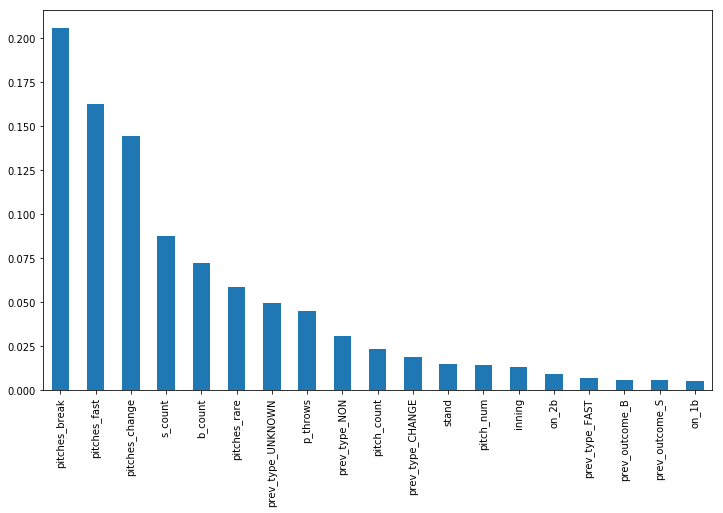

In [73]:
feature_imp = sorted(list(zip(train_data.columns, best_gb.feature_importances_)), 
                     key=lambda x: x[1], reverse=True)[0:19]
plt.figure(figsize = (12,7))
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

This gives pretty similar information, that the pitcher's history is the most indicative of what the next pitch will be. Interestingly, however, this model finds the ball/strike count to be more important than the pitch count and score differential unlike the Random Forest model.

Summary: Pitcher history is the most important (what has he thrown in the past and what was the previous pitch type). The Random Forest and Gradient Boosted models disagreed on what situational data (inning, number of strikes, etc.) were the most important. The importance of situational data would change with different random states, but the pitcher's history consistenly proved to be most important.